In [1]:
cd ..

/home/martinsevilla/langevin_ggm


In [2]:
import numpy as np
import torch
from scipy.stats import wishart
import networkx as nx
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib

import ggm_estimation.predictors as ggmp
import ggm_estimation.data_generation as gen

torch.set_default_device("cuda")
torch.set_default_dtype(torch.float32)

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [3]:
# GMRF parameters
obs_ratio = 1.0
prior_Theta = lambda num_nodes: wishart(num_nodes, np.eye(num_nodes) * 10 / num_nodes)

# Simulation parameters
n, p = 15, 0.25
nans = 0.6
one_zero_ratio = None
n_proportional = True
seed = 1994
psd_trials = 10

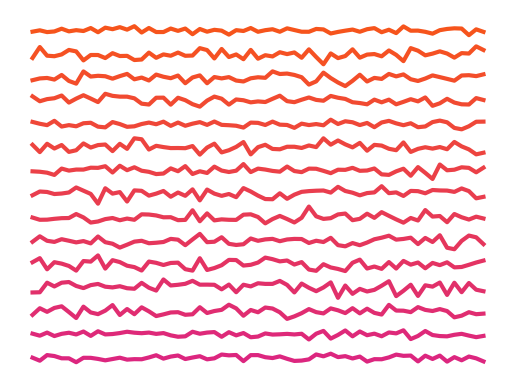

In [4]:
np.random.seed(seed)
random.seed(seed)

A = nx.to_numpy_array(nx.erdos_renyi_graph(n, p))
dataset = [nx.erdos_renyi_graph(n, p, seed=4) for n in [5, 7, 9]]

n_missing = nans if n_proportional is False else np.ceil(nans * A.shape[0] * (A.shape[0] - 1) / 2)
max_num_obs = int(np.ceil(obs_ratio * n_missing))

A_obs, X_obs = gen.simulate_ggm(A, max_num_obs, 
                                nans, one_zero_ratio, n_proportional, psd_trials, prior_Theta, logger=None)

# Add an increasing mean to each column of X_obs
X_obs = X_obs + 3 * np.arange(X_obs.shape[1])

# Change the color cycle cividis
cmap = colors.LinearSegmentedColormap.from_list("Custom", ["#DC267F", "#FE6100"], N=100)
plt.rcParams['axes.prop_cycle'] = plt.cycler("color", cmap(np.linspace(0, 1, X_obs.shape[1] + 4)))

plt.plot(X_obs, linewidth=3)
# Remove the axis
plt.axis('off')
plt.savefig('figures_paper/X.svg')
plt.show()

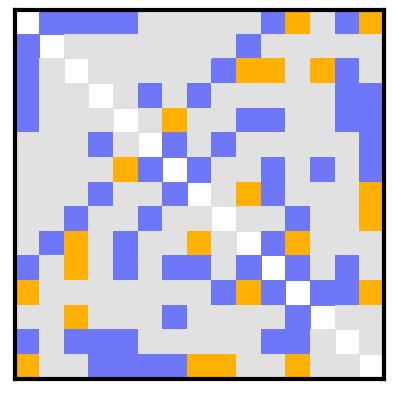

In [5]:
color_0 = "#6E77F8"
color_1 = "#FFB000"
color_1_plus = "#FE6100"
color_nan = '#e1e1e1'
color_diagonal = "white"

A_obs_plot = np.nan_to_num(A_obs, copy=True, nan=0.5)
A_obs_plot[np.diag_indices_from(A_obs)] = np.nan

# Plot A_obs_plot with the colors defined above
cmap = colors.ListedColormap([color_0, color_nan, color_1])
cmap.set_bad(color_diagonal, 1.)
plt.pcolor(A_obs_plot, cmap=cmap)
plt.xticks([])
plt.yticks([])
# Get current axis
ax = plt.gca()
plt.setp(ax.spines.values(), linewidth=3)
# Make the axes square
ax.set_aspect('equal')
ax.invert_yaxis()
plt.savefig('figures_paper/A_obs.svg')
plt.show()

In [6]:
# # Plot the graphs in the dataset side by side
# fig, axs = plt.subplots(1, len(dataset), figsize=(15, 5))
# for i, g in enumerate(dataset):
#     # Spring layout
#     pos = nx.spring_layout(g)
#     nx.draw(g, ax=axs[i], pos=pos)
# plt.tight_layout()
# plt.show()

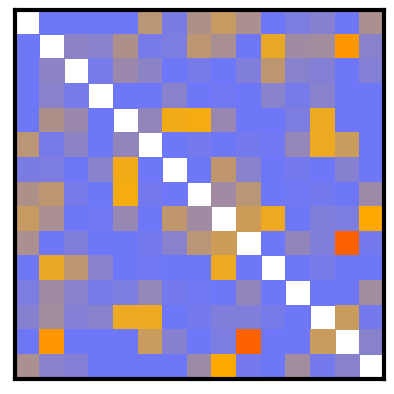

In [7]:
langevin_posterior = ggmp.LangevinEstimator(sigmas=np.linspace(0.5, 0.03, 10), epsilon=None,
											  		steps=None, score_estimator=None,
													use_likelihood=None, use_prior=None)
Theta_hat = np.abs(langevin_posterior._compute_raw_theta(A_obs, X_obs))
Theta_hat[np.diag_indices_from(Theta_hat)] = np.nan

# Define a colormap as a gradient between color_0 and color_1
cmap = colors.LinearSegmentedColormap.from_list("Custom", [color_0, color_1, color_1_plus], N=100)
cmap.set_bad(color_diagonal, 1.)
plt.pcolor(Theta_hat, cmap=cmap)
plt.xticks([])
plt.yticks([])
# Get current axis
ax = plt.gca()
plt.setp(ax.spines.values(), linewidth=3)
ax.set_aspect('equal')
ax.invert_yaxis()
plt.savefig('figures_paper/Theta.svg')
plt.show()

In [8]:
# A_plot = A.copy()
# A_plot[np.diag_indices_from(A_obs)] = np.nan

# cmap = colors.ListedColormap([color_0, color_nan, color_1])
# cmap.set_bad('black', 1.)
# plt.imshow(A_plot, cmap=cmap)

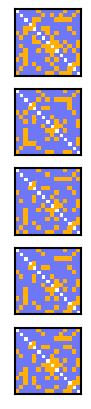

In [9]:
def symmetric_noise(A_obs, sigma):
    noise = np.random.normal(0, sigma, size=A_obs.shape)
    noise = (noise + noise.T) / 2
    # Set 0 where A_obs is not NaN
    noise[~ np.isnan(A_obs)] = 0
    return noise

A_samples = np.array([A + symmetric_noise(A_obs, 0.5) for _ in range(5)])
A_samples = (np.clip(A_samples, 0, 1) > 0.5).astype(float)
# Put NaNs in the diagonal of all the samples
for i in range(A_samples.shape[0]):
    np.fill_diagonal(A_samples[i], np.nan)

cmap = colors.LinearSegmentedColormap.from_list("Custom", [color_0, color_1], N=100)
cmap.set_bad(color_diagonal, 1.)
fig, axs = plt.subplots(A_samples.shape[0], 1, figsize=(15, 5))
for i, A_sample in enumerate(A_samples):
    axs[i].pcolor(A_sample, cmap=cmap)
    # axs[i].axis('off')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    for axis in ['top','bottom','left','right']:
        axs[i].spines[axis].set_linewidth(1.5)
    axs[i].set_aspect('equal')
    axs[i].invert_yaxis()
plt.savefig('figures_paper/A_samples.svg')
plt.show()

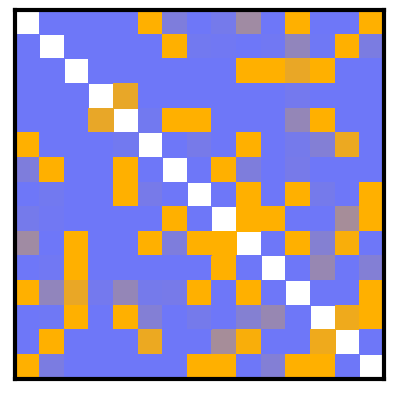

In [10]:
A_hat = symmetric_noise(np.nan * np.ones(A.shape), 0.2) + A
A_hat = np.clip(A_hat, 0, 1)
A_hat[~ np.isnan(A_obs)] = A_obs[~ np.isnan(A_obs)]
A_hat[np.diag_indices_from(A_hat)] = np.nan

cmap = colors.LinearSegmentedColormap.from_list("Custom", [color_0, color_1], N=100)
cmap.set_bad(color_diagonal, 1.)
plt.pcolor(A_hat, cmap=cmap)
plt.xticks([])
plt.yticks([])
# Get current axis
ax = plt.gca()
plt.setp(ax.spines.values(), linewidth=3)
ax.set_aspect('equal')
ax.invert_yaxis()
plt.savefig('figures_paper/A_mean.svg')
plt.show()

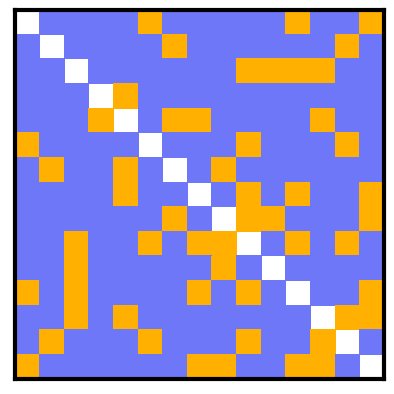

In [11]:
A_est = (A_hat > 0.5).astype(float)
A_est[np.diag_indices_from(A_hat)] = np.nan

cmap = colors.LinearSegmentedColormap.from_list("Custom", [color_0, color_1], N=100)
cmap.set_bad(color_diagonal, 1.)
plt.pcolor(A_est, cmap=cmap)
plt.xticks([])
plt.yticks([])
# Get current axis
ax = plt.gca()
plt.setp(ax.spines.values(), linewidth=3)
ax.set_aspect('equal')
ax.invert_yaxis()
plt.savefig('figures_paper/A_hat.svg')
plt.show()